# 1. Fundamentos de *Machine Learning*

En este notebook se revisarán los conceptos de:

1. Notación
2. Vecinos más próximos
3. Repaso de Pandas
4. Evaluación del modelo: entrenamiento y test
5. Selección del modelo: validación cruzada
6. Conceptos fundamentales de ML
  1. Compromiso sesgo-varianza
  2. Curvas de aprendizaje

Primero cargamos librerías y funciones necesarias, incluyendo las del módulo `utils`:

In [1]:
from utils import plot_decision_boundary, poly_linear_regression, CM_BRIGHT

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
%matplotlib inline

## 1. Notación

Vamos a importar la librería principal de este módulo, scikit-learn. Habitualmente se importa como `sklearn`.

In [2]:
import sklearn
sklearn.__version__

'1.6.1'

Podemos echar un vistazo a los [datasets](http://scikit-learn.org/stable/datasets) de sklearn.

In [3]:
from sklearn import datasets

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

<div class = "alert alert-success">
EJERCICIO 1.1: Sobre el conjunto de datos anterior, el dataset de diabetes, vamos a calcular los siguientes valores:
</div>

* $N$: número de muestras
* $d$: dimensionalidad del espacio de entrada
* $\mathbf{x}^{(10)}$: muestra $i=10$
* $\mathbf{x}_1$: característica/variable/*feature* $1$

In [8]:
# Para resolver el problema, vamos a seguir una serie de pasos.
# Lo primero es saber a qué nos enfrentamos: qué son x e y?

# ... código para analizar qué tipo de datos son X e y
print('X es de tipo', type(X))
print(f'y es de tipo {type(y)}')

# .... código para saber el tamaño (o la forma) de X e y
print('X tiene un tamaño de', X.shape)
print(f'y tiene un tamaño de {y.shape}')

# Sabiendo la forma de X deberíamos ser capaces de determinar el número de muestras y la dimensionalidad

n = X.shape[0]
d = X.shape[1]

print(f'El numero de muestras es {n} y la dimensionalidad es {d}')

X es de tipo <class 'numpy.ndarray'>
y es de tipo <class 'numpy.ndarray'>
X tiene un tamaño de (442, 10)
y tiene un tamaño de (442,)
El numero de muestras es 442 y la dimensionalidad es 10


In [9]:
# En cuanto a la muestra número 10, debemos recordar que Python es zero-indexed

# ... código para extraer el décimo elemento en la primera dimensión de X (es decir, las filas)

x_10 = X[9, :]
print(x_10)

[-0.07090025 -0.04464164  0.03906215 -0.03321323 -0.01257658 -0.03450761
 -0.02499266 -0.00259226  0.06773705 -0.01350402]


In [17]:
# Para la primera característica, también debemos recordar que Python es zero-indexed

# ... código para extraer el primer elemento en la segunda dimensión de X (es decir, las columnas)

x1 = X[:, 0]
print(len(x1))

442


<div class = "alert alert-success">
EJERCICIO 1.2: ¿Es un problema de clasificación o de regresión? ¿Por qué?
</div>

In [19]:
# ¿Cómo podríamos determinar si el problema es de regresión o clasificación? ¿Qué es lo que diferencia a uno de otro?

# ... código
len(np.unique(y))

214

## 2. Vecinos más próximos

En este notebook vamos a trabajar con el algoritmo de KNN en distintos problemas de **clasificación**.

### 2.1. Medida de las prestaciones de un clasificador

Por clasificador entendemos un algoritmo que, a partir de un conjunto de muestras/observaciones de entrenamiento, es capaz de identificar a qué clase (categoría) pertenece una nueva observación.

Una métrica de calidad que podemos usar para medir las prestaciones de un clasificador es el **error de clasificación**

$$\textrm{Error} = \frac{\textrm{núm de muestras mal clasificadas}}{\textrm{núm de muestras total del problema}}$$

* Ejemplo: problema de clasificación con dos clases $y\in{0,1}$
    * Etiquetas reales (*y_true*) = $[1,0,0,1,0]$
    * Etiquetas predichas (*y_pred*) = $[0,0,1,1,0]$
    
    * En este caso: $$\textrm{Error} = \frac{\textrm{núm de muestras mal clasificadas} = 2}{\textrm{núm de muestras total del problema} = 5} = \frac{2}{5} = 0.4$$

Así, el error de clasificación será un número entre 0 y 1, tal que:

* $\textrm{Error} = 0$ es el mejor valor posible (no me equivoco nada)
* $\textrm{Error} = 1$ es el peor valor posible (me equivoco en todas las muestras). Nota: si me equivoco en la clasificación de todas las muestras, entonces puedo interpretar que el clasificador es bueno, pero que tengo que hacer justo lo contrario de lo que me dice. El peor valor de error sería por tanto $0.5$, en el que la incertidumbre es mayor.

Normalmente no se utiliza el error, sino su complementario, la exactitud o [**accuracy**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) (Acc):

$$\textrm{Acc} = 1 - \textrm{Error}$$

y entonces:

* $\textrm{Acc} = 1$ es el mejor valor posible (no me equivoco nada)
* $\textrm{Acc} = 0$ es el peor valor posible (me equivoco en todas las muestras)

### 2.2 Ejemplos

Para analizar el comportamiento del algoritmo de K-NN, utilizaremos tres ejemplos sencillos, como mostraremos a continuación

In [4]:
# ejemplo1
ejemplo1 = pd.read_csv("./data/ex2data1.txt", sep=",", header=None, names=['x1', 'x2', 'label'])
ejemplo1.head(8)

,x1,x2,label
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
5,45.083277,56.316372,0
6,61.106665,96.511426,1
7,75.024746,46.554014,1


In [21]:
# Qué tipo de datos es `ejemplo1`?
type(ejemplo1)

pandas.core.frame.DataFrame

#### 2.2.1 Pequeño desvío: repaso de Pandas

A no ser que alguien me haya engañado, habéis trabajado ya con Pandas. Sin embargo, lo normal es que no os acordéis de nada, así que vamos a hacer un pequeño repaso de las funciones más habituales. No toméis esto como un estudio exhaustivo, ni mucho menos; pero grosso modo os servirá para este módulo.

Vamos a ver los siguientes métodos:

- `.describe()`, que proporciona un pequeño análisis estadístico. El parámetro `include=all` permite añadir variables categóricas
- `.shape`
- `.head()`
- `.tail()`
- `.dtypes`
- Análisis de valores nulos con `.isnull()` e `.isnull().any()`
- Eliminación de columnas con `.drop(c1, axis=1)`
- Cómo acceder a los índices internos, con `.index` y `.index.values`
- Cómo acceder a un elemento determinado en base a su índice, con `.iloc[[i1, i2, i3, ...]]`
- Cómo construir un nuevo dataframe filtrando el anterior, con `df_filtered = df[condición]`
- Cómo construir un nuevo dataframe filtrando el anterior bajo condición múltiple, con `df_filtered = df[(condición 1) & (condición 2)]`


In [22]:
ejemplo1.describe()

,x1,x2,label
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


In [23]:
ejemplo1.shape

(100, 3)

In [25]:
ejemplo1.head(7)

,x1,x2,label
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
5,45.083277,56.316372,0
6,61.106665,96.511426,1


In [27]:
ejemplo1.tail(3)

,x1,x2,label
97,99.315009,68.775409,1
98,55.340018,64.931938,1
99,74.775893,89.529813,1


In [33]:
ejemplo1.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      100 non-null    float64
 1   x2      100 non-null    float64
 2   label   100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [35]:
ejemplo1.isnull().any()

x1       False
x2       False
label    False
dtype: bool

In [36]:
ejemplo1.dtypes

x1       float64
x2       float64
label      int64
dtype: object

In [48]:
copia = ejemplo1.copy()
copia.drop(['x1'], axis=1, inplace=True)
copia.head()

,x2,label
0,78.024693,0
1,43.894998,0
2,72.902198,0
3,86.308552,1
4,75.344376,1


In [41]:
ejemplo1.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [49]:
ejemplo1.iloc[[3, 4, 5]]

,x1,x2,label
3,60.182599,86.308552,1
4,79.032736,75.344376,1
5,45.083277,56.316372,0


In [51]:
ejemplo1_filtered = ejemplo1[(ejemplo1['x1']>50) & (ejemplo1['x2']<80)]

In [53]:
ejemplo1.head(5)

,x1,x2,label
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [54]:
ejemplo1_filtered.head()

,x1,x2,label
4,79.032736,75.344376,1
7,75.024746,46.554014,1
9,84.432820,43.533393,1
10,95.861555,38.225278,0
11,75.013658,30.603263,0


Una vez estudiado el dataframe, podemos representar:

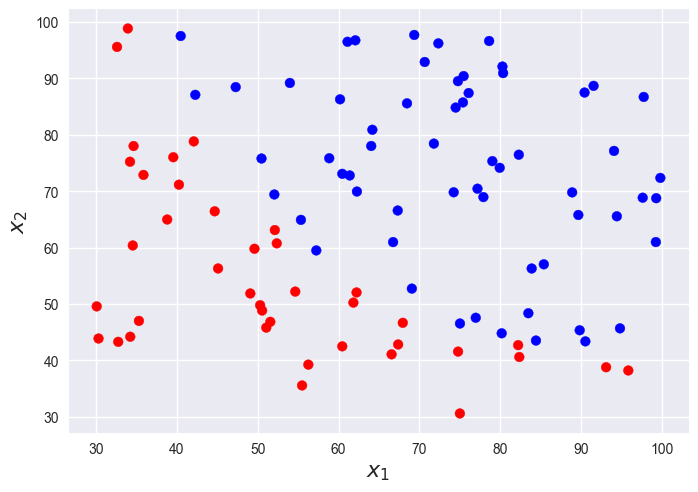

In [5]:
plt.scatter(ejemplo1['x1'], ejemplo1['x2'], c=ejemplo1['label'], cmap=CM_BRIGHT)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.show()

Se dice que este problema es **linealmente separable**, porque podemos trazar una recta para separar las dos clases (representadas en distintos colores, rojo y azul).
* En el plano bidimensional: recta
* En un espacio d-dimensional: hiperplano

Nota: No es linealmente separable puesto que la separación no es perfecta. Pero es _casi_ linealmente separable, aceptamos.

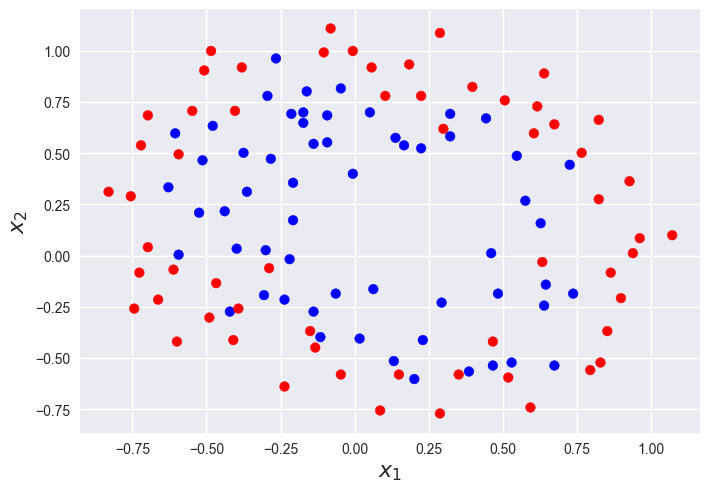

In [6]:
# ejemplo2
ejemplo2 = pd.read_csv("./data/ex2data2.txt", sep=",", header=None, names=['x1', 'x2', 'label'])

plt.scatter(ejemplo2['x1'], ejemplo2['x2'], c=ejemplo2['label'], cmap=CM_BRIGHT)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.show()

Se dice que este problema es **no linealmente separable**, porque no podemos trazar una recta para separar las dos clase (representadas en distintos colores, rojo y azul).

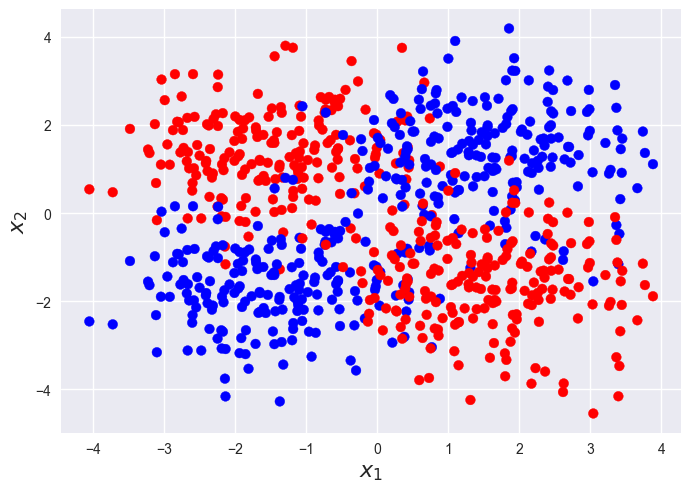

In [7]:
# ejemplo 3: Problema XOR
np.random.seed(0)

# -- parameters
N     = 800
mu    = 1.5      # Cambia este valor
sigma = 1      # Cambia este valor

# variables auxiliares
unos = np.ones(int(N/4))
random4 = sigma*np.random.randn(int(N/4),1)
random2 = sigma*np.random.randn(int(N/2),1)

# -- features
y3 = np.concatenate([-1*unos, unos, unos, -1*unos])
X1 = np.concatenate([-mu + random4, mu + random4, -mu + random4, mu + random4])
X2 = np.concatenate([+mu + random2, -mu + random2])
X3 = np.hstack((X1,X2))

plt.scatter(X3[:,0], X3[:,1], c=y3, cmap=CM_BRIGHT)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.show()

Al igual que en el caso anterior, este ejemplo tampoco es linealmente separable, y se conoce como problema XOR. La ventaja del problema XOR es que conocemos cuál es la frontera de separación óptima a priori:

- Clase 1, color azul: $x_1,x_2 > 0$, y $ x_1,x_2 < 0$ (cuadrantes 1 y 3)
- Clase 2, color rojo: $x_1 < 0,  x_2 > 0$, y $x_1 > 0,  x_2 < 0$ (cuadrantes 2 y 4)

## 2.3 Entrenar el modelo

Vamos a entrenar un [modelo K-NN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) para los distintos ejemplos:

El tipo de datos es <class 'numpy.ndarray'>


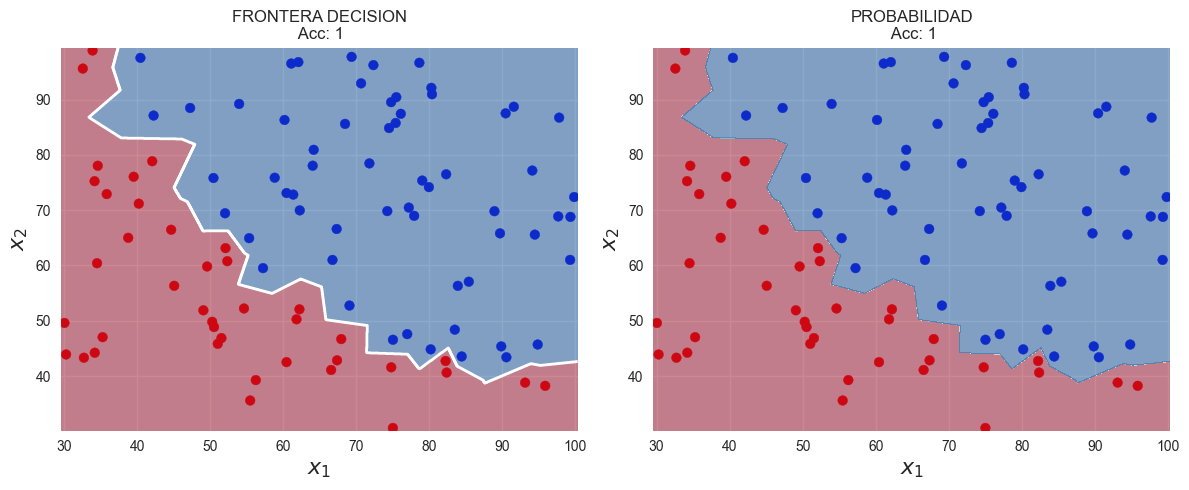

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# Ejemplo 1
# preparamos los datos
data1 = ejemplo1.values
print(f'El tipo de datos es {type(data1)}')
X1 = data1[:, 0:2]
y1 = data1[:, -1]

# creamos el modelo y ajustamos
knnModel = KNeighborsClassifier(n_neighbors=1).fit(X1, y1)

plot_decision_boundary(X1, y1, knnModel)

> NOTA: Fijaos que para entrenar utilizamos `.fit()`. Esto entrena el modelo con todos los datos disponibles, lo que se conoce como batch learning; la alternativa es entrenar con pequeños conjuntos de datos nuevos a medida que van llegando: online learning. La inmensa mayoría de algoritmos en scikit learn están diseñados para batch learning, pero algunos tienen implementada una opción para entrenamientos parciales, `partial_fit`. Para más info, echad un ojo a [la documentación](https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning).

> Más info sobre batch, mini-batch y online learning [aquí](https://www.kaggle.com/code/residentmario/full-batch-mini-batch-and-online-learning)

**Número de vecinos**

Podemos modificar el número de vecinos $k$ del algoritmo k-nn implementado en scikit-learn mediante el parámetro *n_neighbors*. Por defecto, [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) toma *n_neighbors* $=5$

<div class = "alert alert-success">
EJERCICIO 1.3: Varía el valor de <b>n_neighbors</b>, ¿qué sucede ahora?
</div>

<div class = "alert alert-success">
EJERCICIO 1.4: Aplica el algoritmo K-NN sobre los ejemplos 2 y 3. ¿Qué sucedería si aplicamos sobre estos ejemplos un algoritmo de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">regresión logística</a>? ¿Qué pasa si variamos el número de vecinos?
</div>

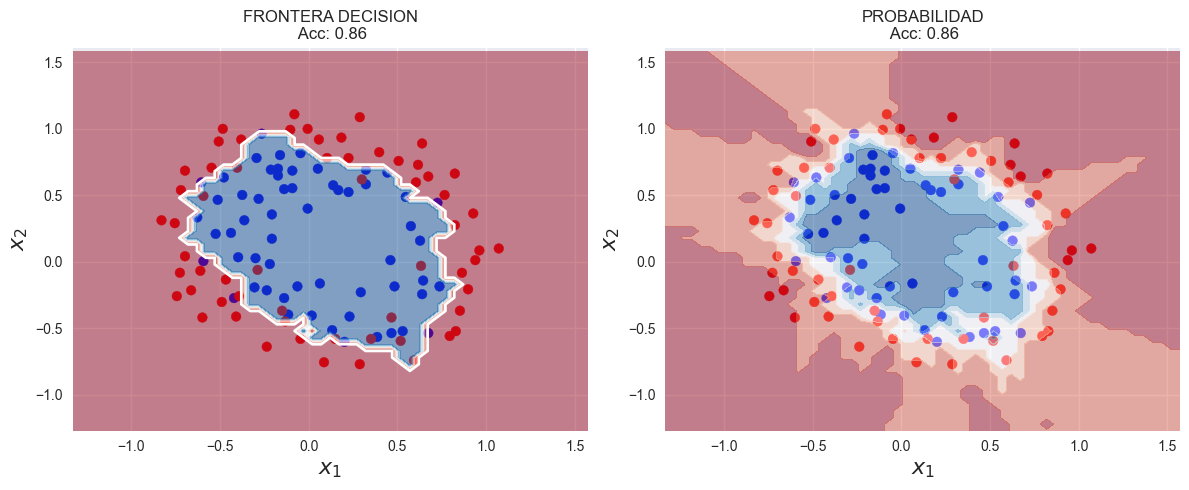

In [66]:
# Ejemplo 2
from sklearn.neighbors import KNeighborsClassifier

# ... código para preparar los datos
data2 = ejemplo2.values
X2 = data2[:, 0:2]
y2 = data2[:, -1]

# ... código para crear el modelo y entrenar
knnModel2 = KNeighborsClassifier(n_neighbors=5).fit(X2, y2)

plot_decision_boundary(X2, y2, knnModel2)

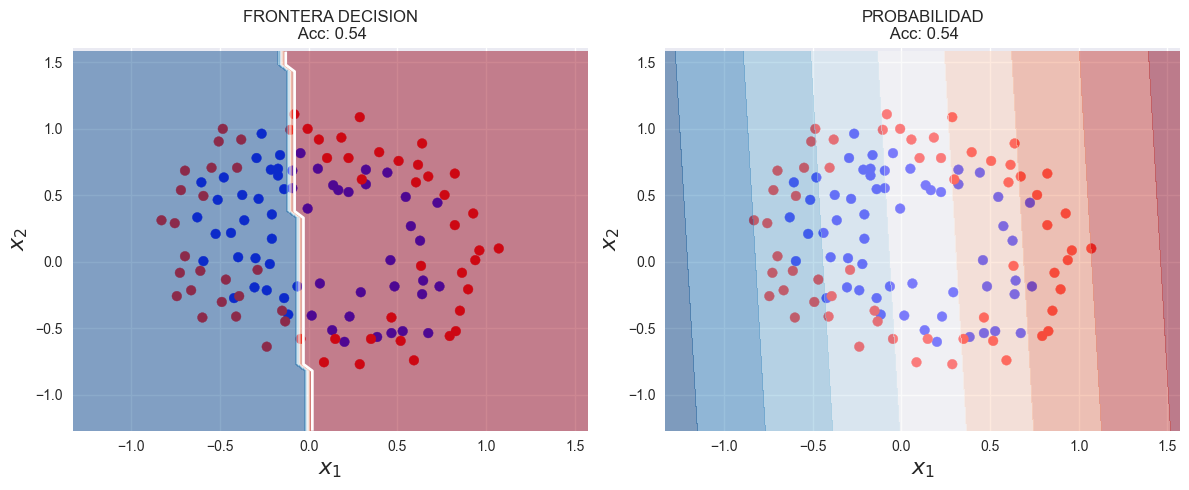

In [72]:
from sklearn.linear_model import LogisticRegression

# .... código para crear el modelo y entrenar
lrModel = LogisticRegression().fit(X2, y2)
plot_decision_boundary(X2, y2, lrModel)

No funciona bien, ¿no? ¿Qué creéis que está pasando?

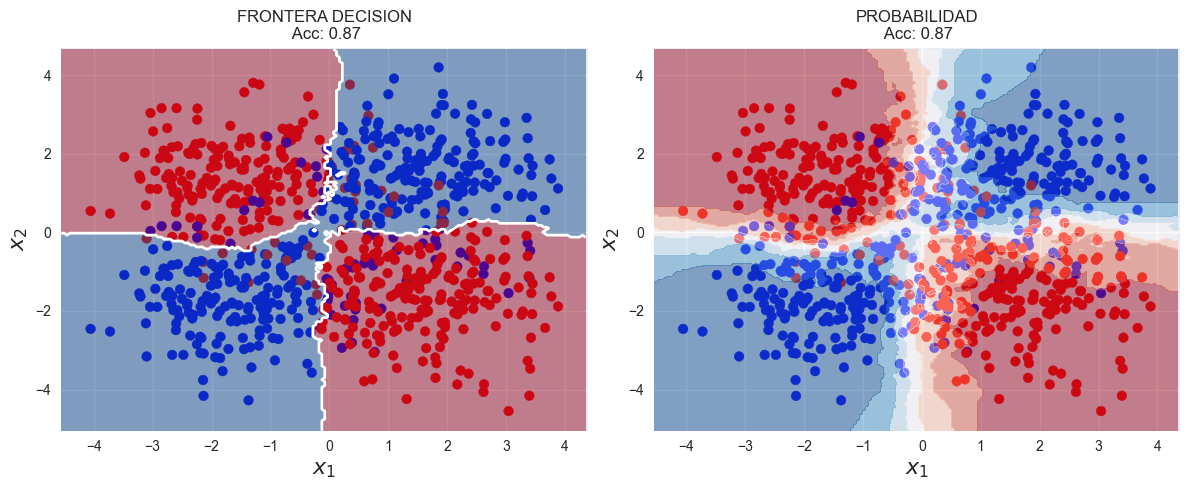

In [77]:
# Ejemplo 3
from sklearn.neighbors import KNeighborsClassifier

# ... código para crear el modelo y entrenar
knnModel3 = KNeighborsClassifier(n_neighbors=20).fit(X3, y3)

plot_decision_boundary(X3, y3, knnModel3)

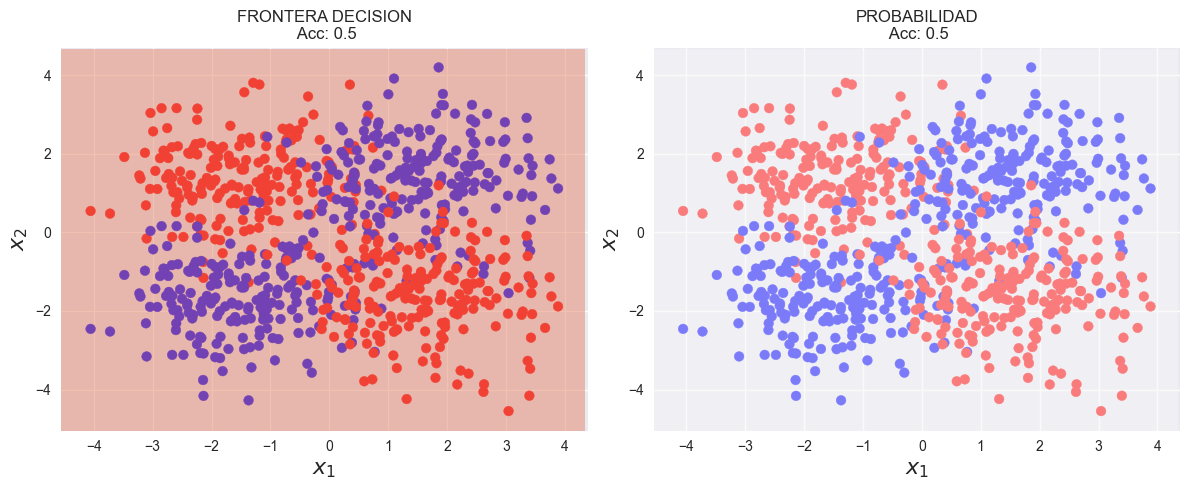

In [73]:
from sklearn.linear_model import LogisticRegression

# .... código para crear el modelo y entrenar
lrModel3 = LogisticRegression().fit(X3, y3)
plot_decision_boundary(X3, y3, lrModel3)

Podemos comprobar que las mejores prestaciones se obtienen cuando *n_neighbors=1*, ¿tiene sentido? ¿Estamos midiendo correctamente las prestaciones de este clasificador?

# 3. Evaluación del modelo: entrenamiento y test

La respuesta es claramente no. Para poder saber cómo de bien se comporta un algoritmo de machine learning, hemos de medir su capacidad de [generalización](https://en.wikipedia.org/wiki/Generalization_error), esto es, las prestaciones en muestras no vistas previamente por el clasificador. Para ello, dividimos el conjunto de entrenamiento en dos partes, entrenamiento y test, teniendo en cuenta que:

![](./figuras/train_test_set_2d_classification.png)

* Utilizamos aproximadamente un 75-80% de las muestras para entrenamiento y un 25-20% para el test (cuidado! depende del tamaño del dataset; si es muy grande, el conjunto de test puede ser un porcentaje menor)
* Ambos conjuntos han de representar la población con la misma estadística:
    * Randomizar, esto es, reordenar para evitar orden en las muestras. (cuidado series temporales)
    * Estratificar con respecto a una variable (normalmente la variable target), para mantener la proporción de la varible target en los conjuntos train/test.

sklearn nos proporciona una [función](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para dividir nuestros datos.

Vamos a probar con el primer ejemplo:

<class 'numpy.ndarray'>


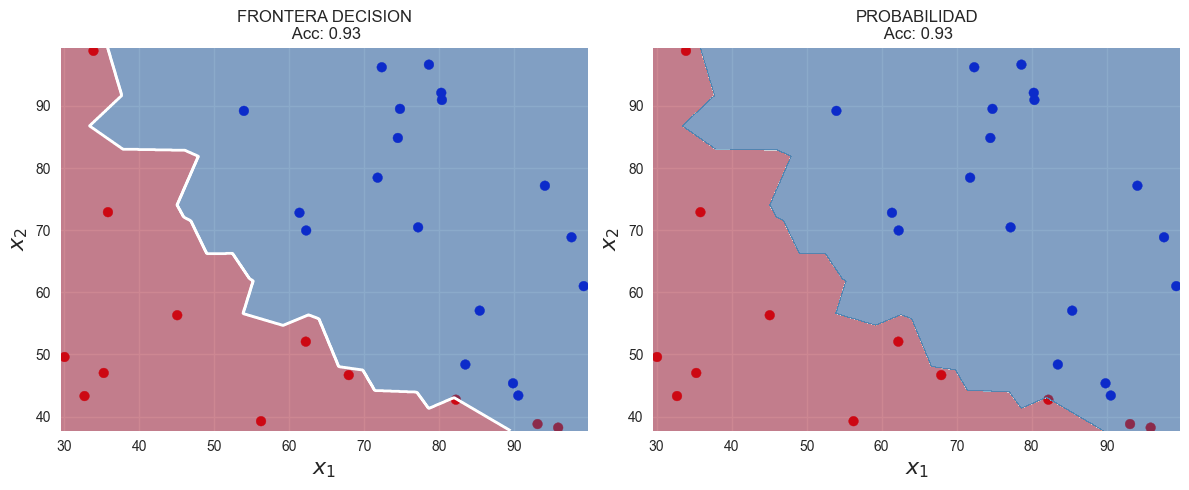

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, shuffle = True, stratify=y1)

print(type(X_train))

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

plot_decision_boundary(X_test, y_test, knn)

<div class = "alert alert-success">
EJERCICIO 1.5: Sobre la celda anterior, varía el valor de <b>n_neighbors</b>. ¿Para qué valor se obtienen ahora las mejores prestaciones? ¿Qué sucede si eliminamos <b>random_state = 0</b> y ejecutamos varias veces la misma celda para un valor de <b>n_neighbors</b> fijo? ¿Obtenemos las mismas prestaciones?
</div>

<div class = "alert alert-success">
EJERCICIO 1.6: Calcula las prestaciones del algoritmo K-NN para los ejemplos 2 y 3.
</div>

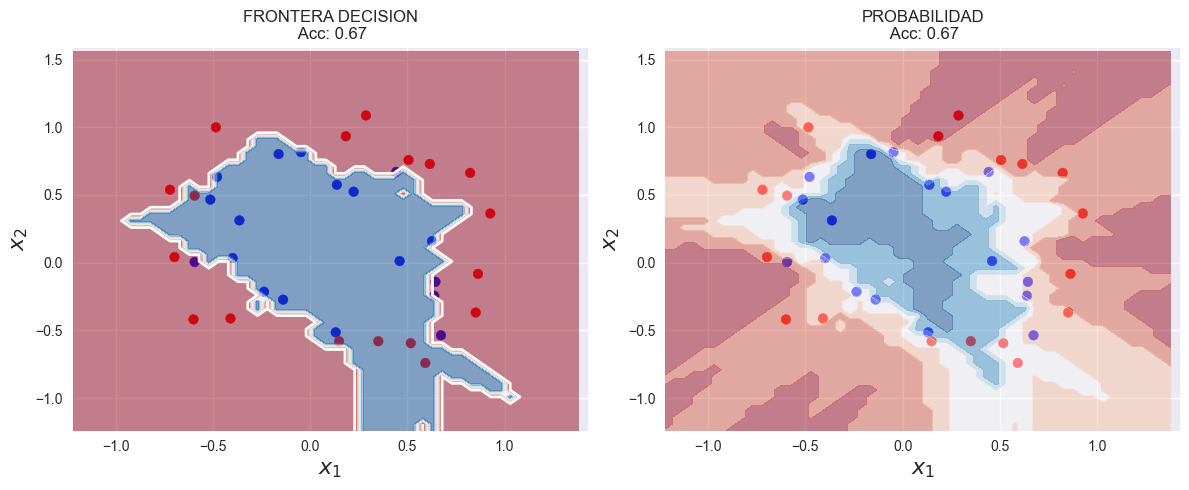

In [85]:
# Ejemplo 2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3, shuffle = True, stratify=y2)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

plot_decision_boundary(X_test, y_test, knn)

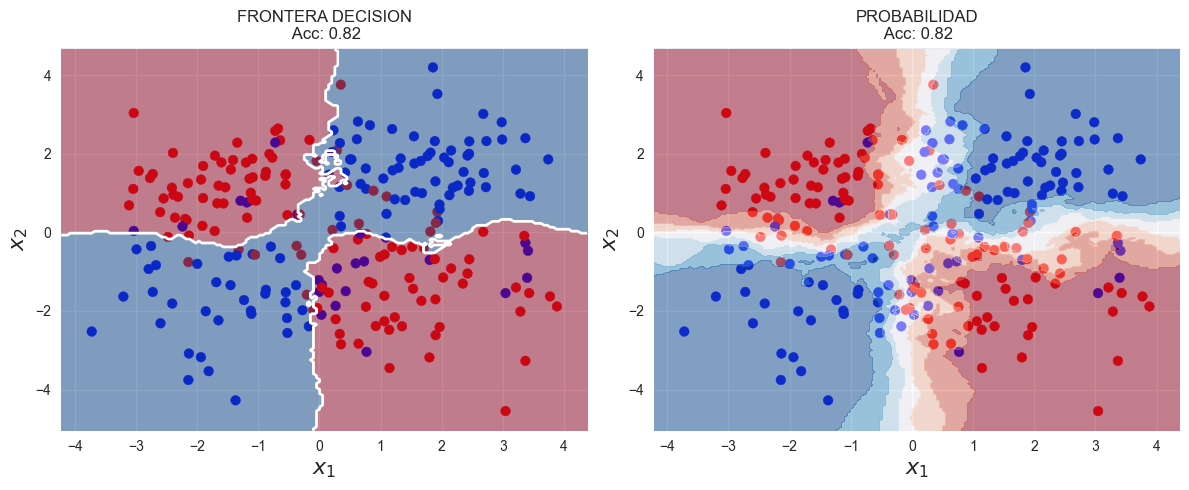

In [110]:
# Ejemplo 3
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, shuffle = True, stratify=y3)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

plot_decision_boundary(X_test, y_test, knn)

<div class = "alert alert-success">
EJERCICIO 1.7: Vamos a realizar un análisis del parámetro de estratificación, para ver el efecto que tiene en los datos
</div>

In [112]:
# Una forma de estudiarlo
ejemplo1['label'].value_counts()

label
1    60
0    40
Name: count, dtype: int64

In [115]:
# Otra forma de estudiarlo
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([28, 42]))

In [116]:
# Ahora: cómo haríais el análisis completo?
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, shuffle = True, random_state=3)
print('*'*30)
print('Sin estratificar')
print(f'Train: {((np.unique(y_train, return_counts=True))[1][0])/len(y_train)}')
print(f'Test: {((np.unique(y_test, return_counts=True))[1][0])/len(y_test)}')
print('*'*30)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, shuffle = True, random_state=3, stratify=y1)
print('Estratificando')
print(f'Train: {((np.unique(y_train, return_counts=True))[1][0])/len(y_train)}')
print(f'Test: {((np.unique(y_test, return_counts=True))[1][0])/len(y_test)}')
print('*'*30)

******************************
Sin estratificar
Train: 0.44285714285714284
Test: 0.3
******************************
Estratificando
Train: 0.4
Test: 0.4
******************************


<div class = "alert alert-success">
EJERCICIO 1.8 (AVANZADO): Representa las prestaciones del algoritmo K-NN en entrenamiento y test para distintos valores de <b>n_neighbors</b> (entre 1 y 15), utilizando el ejemplo 3.
</div>

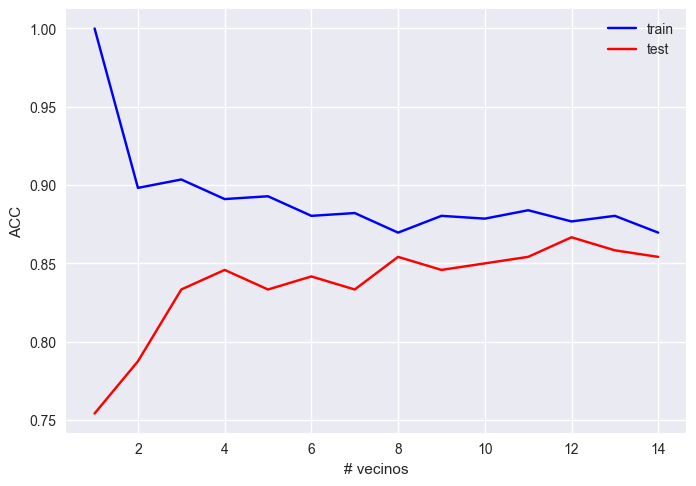

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, shuffle = True)

# inicializamos
neighbors = range(1,15)
acc_train = []
acc_test  = []

for n in neighbors:

    knn = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    # pista: lo único que hay que hacer es instanciar el modelo,
    # definiendo correctamente el parámetro del número de vecinos,
    # y luego hacer `.fit()` sobre los datos de train    

    acc_train.append(knn.score(X_train, y_train))
    acc_test.append(knn.score(X_test, y_test))


plt.plot(neighbors,acc_train,'b',label='train')
plt.plot(neighbors,acc_test,'r',label='test')
plt.legend()
plt.xlabel('# vecinos')
plt.ylabel('ACC')
plt.show()


El número de vecinos que escojamos afecta significativamente a las prestaciones del algoritmo. Este parámetro es un compromiso entre los errores que cometemos (*accuracy*) y la complejidad del modelo (frontera de separación).

- Cuanto menor es el número de vecinos, **más compleja** es la frontera de separación, y por tanto mayor será el sobreajuste. Potencialmente empeorará la *accuracy*.
- Cuanto mayor es el número de vecinos, **menos compleja** es la frontera de separación y por tanto menor será el sobreajuste. Potencialmente mejorará la *accuracy*.

## 3.1 Conclusiones

1. Si las muestras de entrenamiento son escasas (ejemplo 1), el error en test puede ser muy variable , dependiendo de las muestras incluidas en el conjunto de entrenamiento y el conjunto de test.

2. Las prestaciones (en test), dependen del número de vecinos que determinan la complejidad de la frontera de separación.

Teniendo en cuenta 1 y 2, ¿cómo puedo escoger el valor óptimo de *n_neighbors*?

Vamos a volver a teoría un momentito y lo vemos allí.


# 4. Selección del modelo: validación cruzada

La validación cruzada (o cross-validation) consiste en subdivir el conjunto de entrenamiento en $K$ partes iguales, de tal forma que se utilizan $K-1$ para entrenar (ajustar el modelo) y el bloque $k$ restante para evaluar las prestaciones en función de los parámetros libres. Este proceso se repite $K$ veces (hasta que se barren todos los bloques) y los resultados se promedian.

Por suerte, no es necesario programar estas subdivisiones, porque scikit-learn tiene un clase que realiza este trabajo por nosotros. Puedes consultarlo [aquí](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

Vamos a buscar el valor óptimo del número de vecinos utilizando una estrategia 5-fold CV.

In [23]:
from sklearn.model_selection import StratifiedKFold

# recordemos que este es nuestro conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, shuffle = True, random_state = 0, stratify=y3)

nFolds = 5 #scikit-learn los llama splits
kf  = StratifiedKFold(n_splits = nFolds, shuffle = True, random_state=0)

nVecinos = range(1,16) # [1-15]

# inicializamos una matriz de errores, para cada valor de n_neighbors y cada iteración del algoritmo de cross-validation
# - tantas filas como número de folds
# - tantas columnas como valores de alphaVector
accMatriz = np.zeros((nFolds,len(nVecinos)))

j = 0 # inicializamos contador de columnas
for n in nVecinos:

    knn = KNeighborsClassifier(n_neighbors = n)

    i = 0 # inicializamos contador de filas
    for idxTrain, idxVal in kf.split(X_train,y_train):

        Xt = X_train[idxTrain,:]
        yt = y_train[idxTrain]
        Xv = X_train[idxVal,:]
        yv = y_train[idxVal]

        knn.fit(Xt,yt)
        accMatriz[i,j] = knn.score(Xv, yv)

        i+=1
    j+=1

accVector = np.mean(accMatriz,axis=0)
accStd = np.std(accMatriz,axis=0)

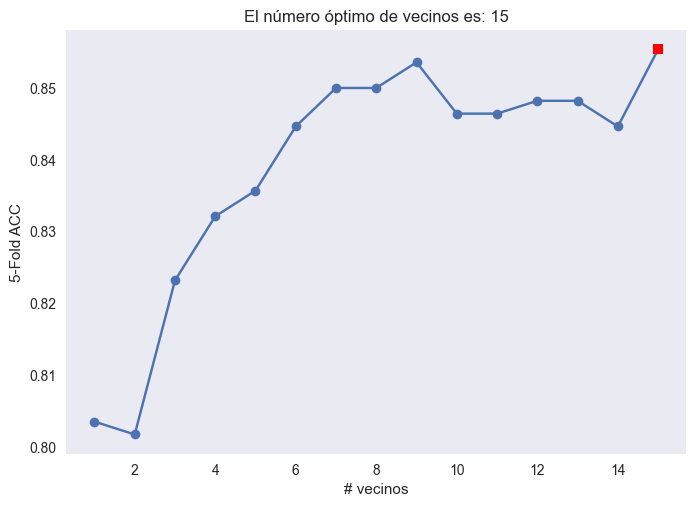

In [24]:
# Calculamos el valor óptimo
idx = np.argmax(accVector)
nOpt = nVecinos[idx]

plt.plot(nVecinos,accVector,'-o')
plt.plot(nVecinos[idx],accVector[idx],'rs')
plt.title('El número óptimo de vecinos es: %d' % nOpt)
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

Representemos ahora la gráfica anterior con la variación (desviación estándar) de la *accuracy* en cada *fold*.

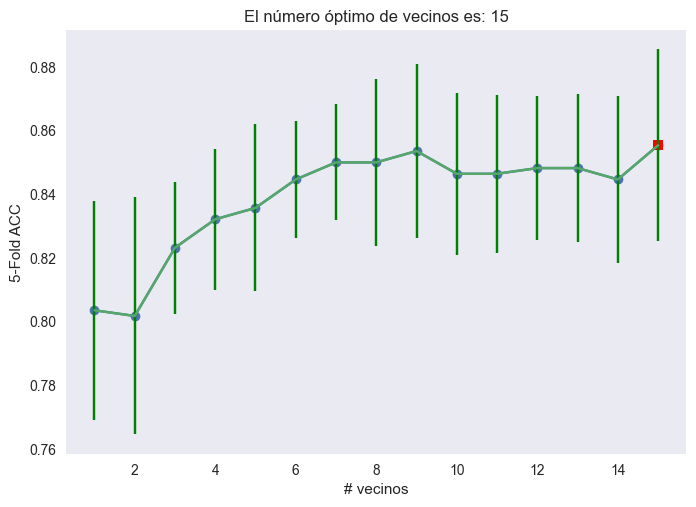

In [25]:
plt.plot(nVecinos,accVector,'-o')
plt.plot(nVecinos[idx],accVector[idx],'rs')
plt.errorbar(nVecinos, accVector, yerr=accStd, ecolor='g')
plt.title('El número óptimo de vecinos es: %d' % nOpt)
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

In [26]:
# Damos las prestaciones reales del modelo (en test)
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train,y_train)

print("accuracy: {:.2f}".format(knn.score(X_test, y_test)))

accuracy: 0.88


El código anterior se puede reducir drásticamente si utilizamos [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Pido perdón por el susto. Aún así, a veces será necesario implementar validación cruzada con KFold si necesitamos más control sobre el proceso, así que tampoco está mal verlo en detalle.

El código de la siguiente celda es equivalente al de las cuatro celdas anteriores:

In [27]:
np.arange(1, 16, 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

Fitting 5 folds for each of 15 candidates, totalling 75 fits
best mean cross-validation score: 0.864
best parameters: {'n_neighbors': 11}


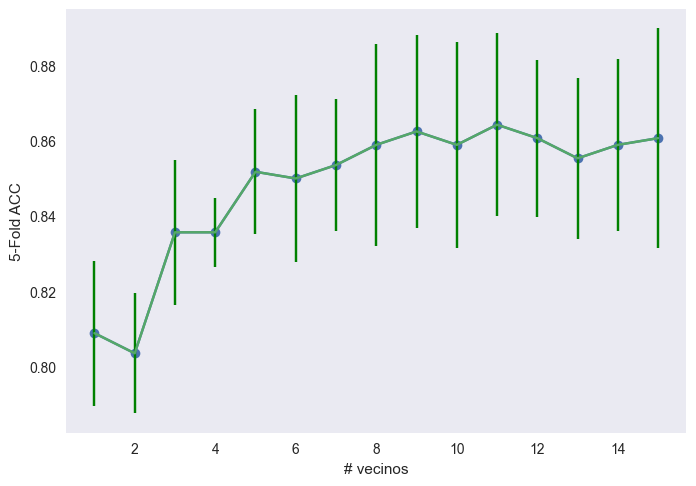

acc (test): 0.84


In [30]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, shuffle = True, random_state = 0)

param_grid = {'n_neighbors':  [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]}
grid = GridSearchCV(KNeighborsClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5, verbose=1).fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score']) #¡cuidado, lo llaman test cuando es validación!
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(np.arange(1, 16, 1),scores,'-o')
plt.errorbar(nVecinos, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# vecinos')
plt.ylabel('5-Fold ACC')
plt.grid()
plt.show()

print("acc (test): {:.2f}".format(grid.score(X_test, y_test)))

# 5. ¿Cómo elegimos el algoritmo adecuado?

No hay *free lunch*, ningún método/algoritmo es mejor que otro para todos los problemas (conjuntos de datos). Para entender si el algoritmo adecuado se comporta adecuadamente, hay que tener en cuenta:

- Ruido en los datos (error irreducible)
- Número de ejemplos disponibles
- Número de características (dimensionalidad del problema)

## 5.1 Compromiso sesgo-varianza

Supongamos que tenemos un proceso $y = g(x) + \epsilon$, donde $\epsilon$ representa una fuente de error irreducible (ruido en los datos). Del proceso $y$, tenemos información de un conjunto de muestras  $D = \{x^{(i)},y^{(i)}\}$, con $i=1,\ldots,N$.

A partir de estos datos $D$, buscamos encontrar la función $f_{\omega}(x)$ que *mejor se ajuste* a la verdadera función $g(x)$, utilizando un algoritmo de *machine learning*. Por mejor ajuste se entiende que se quiere medir el error cuadrático medio $\left(y - f_{\omega}(x)\right)^2$, tanto para el conjunto $D$, como para cualquier muestra no contenida en $D$ (capacidad de generalización).

Dado que $y$ es un proceso que contiene ruido, es difícil que podamos ajustar $f_{\omega}(x)$ a $g(x)$ de forma perfecta. Se puede demostrar que, en promedio, el error que se comete para cualquier valor de $x\notin D$ (error de generalización), se descompone en:

$$ \textrm{error}(x) = E\Big[\big(y - f_{\omega}(x)\big)^2\Big] = \textrm{Bias}\big[f_{\omega}(x)\big]^2 + \textrm{Var}\big[f_{\omega}(x)\big] + \sigma^2 $$

Donde:

* $\textrm{Bias}\big[f_{\omega}(x)\big]^2 = E\Big[f_{\omega}(x)\Big]^2 - g(x)$ representa el error asociado a la simplicidad del modelo.
* $\textrm{Var}\big[f_{\omega}(x)\big]$ representa la variabilidad del modelo frente a distintos conjuntos de entrenamiento. Pequeños cambios en el conjunto de entrenamiento pueden producir grandes errores.
* $\sigma^2$ es una cota al error mínimo que puedo alcanzar.

Por tanto, el objetivo es buscar un algoritmo que proporcione mínimo sesgo y mínima varianza.

### 5.1.1 Ejemplo

Veamos con un ejemplo. Supongamos que $y = g(x) + \epsilon$, donde:

* $g(x) = \cos{(1.5\pi x})$, $x \in [0,1]$
* $\epsilon \sim N(0,\sigma^2)$, $\sigma = 0.2$
* Disponemos del conjunto de datos $D = \{x^{(i)},y^{(i)}\}$, con $i=1,\ldots,N$.

Queremos estimar $g(x)$ a partir del conjunto de datos $D$ disponible. Para ello, vamos a utilizar tres funciones:

* Regresión lineal orden 1: modelo **sencillo** $$f^1_{\omega}(x) = \omega_0 + \omega_1 x$$
* Regresión lineal orden 4: modelo **intermedio** $$f^4_{\omega}(x) = \omega_0 + \omega_1 x + \omega_2 x^2 + \omega_3 x^3 + \omega_4 x^4$$
* regresión lineal orden 7: modelo **flexible** (complejo) $$f^{7}_{\omega}(x) = \omega_0 + \sum_{j=1}^{7}\omega_j x^j$$

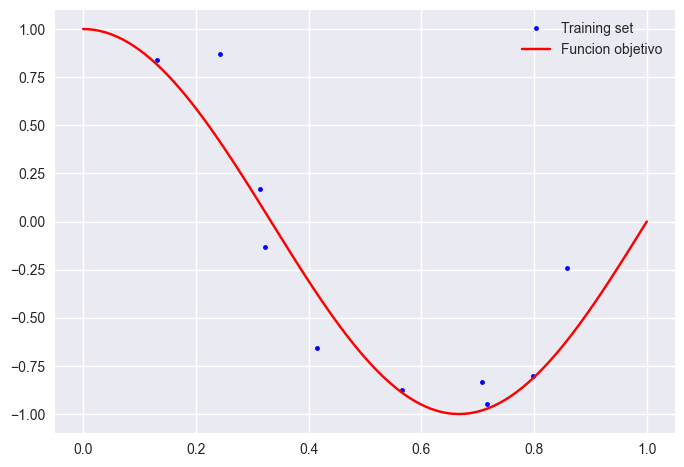

In [32]:
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0,1,N_test)
g_x = np.cos(1.5*np.pi*x)

# proceso y
np.random.seed(0) # para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0,N_test,N_train)
x_i = x[idx]
y_i = y[idx]

# Representamos la función g(x), y el conjunto de datos x_i, y_i
plt.plot(x_i, y_i, 'b.', label='Training set')
plt.plot(x, g_x, 'r', label='Funcion objetivo')
plt.legend()
plt.show()

A continuación representamos la salida obtenida y el error cometido para las tres funciones definidas.

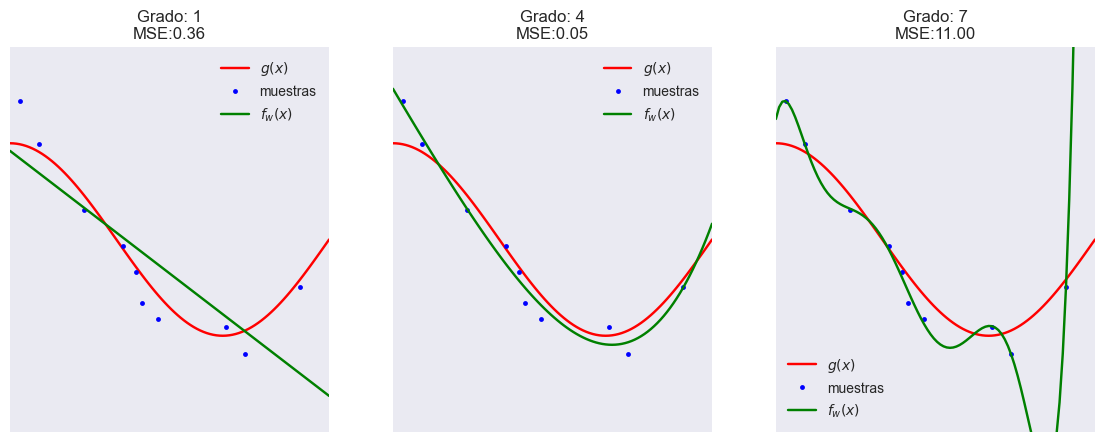

In [38]:
# Ejecute esta celda
grado_polinomio = [1,4,7]

idx = np.random.randint(0,N_test,N_train)
x_i = x[idx]
y_i = y[idx]

plt.figure(figsize=(14, 5))
for j,d in enumerate(grado_polinomio):

    f_k, mse, _ = poly_linear_regression(x_i,y_i,x,y,d)

    ax = plt.subplot(1, 3, j+1)
    plt.setp(ax, xticks=(), yticks=())
    plt.plot(x,g_x,'r',label='$g(x)$')
    plt.plot(x_i,y_i,'b.',label='muestras')
    plt.plot(x,f_k,'g',label='$f_w(x)$')
    plt.title('Grado: %i\nMSE:%.2f'%(d,mse))
    plt.legend()
    plt.xlim((0, 1))
    plt.ylim((-2, 2))

plt.show()

Se puede comprobar que el modelo de orden 7 se **sobreajusta** a las muestras de entrenamiento (la función pasa por los puntos de entrenamiento), y por tanto su capacidad de generalización es muy limitada.

<div class = "alert alert-success">
EJERCICIO 1.9: Descomenta las líneas de código y vuelva a ejecutar la celda, ¿qué resultado obtienes ahora?
</div>

Por tanto, para analizar el sesgo y la varianza de los modelos anteriores, tenemos que calcular sus prestaciones para distintos conjuntos de entrenamiento, y posteriormente calcular su media y su varianza.

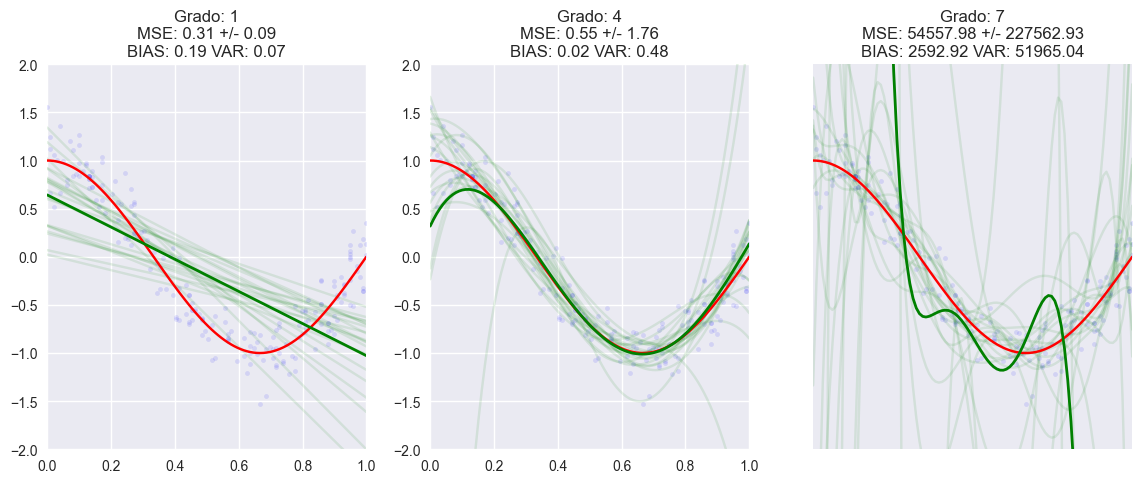

In [46]:
import warnings
warnings.filterwarnings("ignore")

N = 10
grado_polinomio = [1,4,7]
Nrepeticiones = 20

# inicializamos
mse  = np.zeros((len(grado_polinomio),Nrepeticiones))
f_w  = np.zeros((Nrepeticiones,N_test,len(grado_polinomio)))
np.random.seed(0)

plt.figure(figsize=(14, 5))
for k in range(Nrepeticiones):

    y = g_x + np.random.randn(N_test) * 0.2

    # Obtenemos las muestras de un nuevo conjunto de entrenamiento
    idx = np.random.randint(0,N_test,N_train)
    x_i = x[idx]
    y_i = y[idx]

    for j,d in enumerate(grado_polinomio):

        f_k, mse[j,k], _ = poly_linear_regression(x_i,y_i,x,y,d)
        f_w[k,:,j] = f_k

        ax = plt.subplot(1, 3, j+1)
        plt.plot(x_i,y_i,'b.',alpha=0.1)
        plt.plot(x,f_k,'g',alpha=0.1)


for j,d in enumerate(grado_polinomio):
    ax1 = plt.subplot(1, 3, j+1)
    f_k = np.mean(f_w[:,:,j],axis=0)

    bias = g_x - f_k
    var = np.var(f_w[:,:,j],axis=0)

    plt.setp(ax, xticks=(), yticks=())
    plt.plot(x,g_x,'r')
    plt.plot(x,f_k,'g',linewidth=2)
    plt.title('Grado: %i\nMSE: %.2f +/- %.2f\nBIAS: %.2f VAR: %.2f'%(d,
                                                                     np.mean(mse[j,:]),
                                                                     np.std(mse[j,:]),
                                                                     np.mean(bias**2),
                                                                     np.mean(var)))
    plt.ylim((-2, 2))
    plt.xlim((0, 1))

plt.show()



El resultado anterior nos indica que modelos muy complejos tienden a sobreajustarse a los datos (alta varianza), mientras que modelos muy sencillos (alto sesgo), no consiguen aproximarse adecuadamente. Así, el compromiso buscar un algoritmo que tenga mínimo sesgo y mínima varianza.

Así:

* Para reducir el sesgo, se necesitan modelos más complejos
* Para reducir la varianza, se necesita reducir la complejidad. Una opción es aumentar el número de muestras de entrenamiento.


Vamos ahora a representar el error cuadrático medio (entrenamiento y test) para distintos niveles de complejidad del algoritmo de regresión lineal (distintos grados del polinomio)

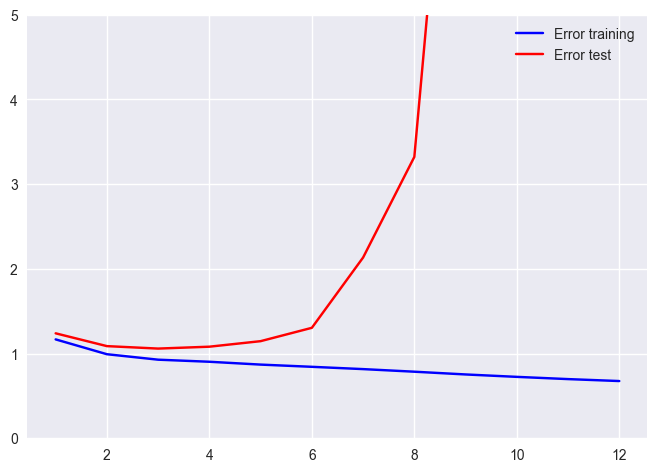

In [45]:
N = 50
grado_polinomio = [1,2,3,4,5,6,7,8,9,10,11,12]
Nrepeticiones = 100

# inicializamos
mse_test  = np.zeros((len(grado_polinomio),Nrepeticiones))
mse_train  = np.zeros((len(grado_polinomio),Nrepeticiones))
np.random.seed(0)

for k in range(Nrepeticiones):

    y = g_x + np.random.randn(N_test) * 1

    idx = np.random.randint(0,N_test,N)
    x_i = x[idx]
    y_i = y[idx]

    for j,d in enumerate(grado_polinomio):

        _, mse_test[j,k], mse_train[j,k] = poly_linear_regression(x_i,y_i,x,y,d)

# Representamos
plt.plot(grado_polinomio, np.mean(mse_train, axis=1), 'b', label='Error training')
plt.plot(grado_polinomio, np.mean(mse_test, axis=1), 'r', label='Error test')
plt.ylim(0, 5)
plt.legend()
plt.show()

Deberías obtener algo como:

![](figuras/entrenamiento_test_complejidad.png)

Fuente: *The Elements of Statistical Learning*

Por tanto, examinando la diferencia en las prestaciones entre el conjunto de entrenamiento/validación y test, puedes saber si estás en alguna de las siguientes situaciones:

* **Alto sesgo**: error de entrenamiento/validación y error en test similar, pero muy alto. Cuando esto sucede podemos
    * Aumentar el número de variables / características
    * Aumentar el grado del polinomio (mayor complejidad)
* **Alta varianza**: gran diferencia entre error de entrenamiento/validación y test con un error de entrenamiento pequeño
    * Aumentar el número de muestras de entrenamiento
    * Reducir el número de variables / características


## 5.2 Número de ejemplos disponibles

De la discusión anterior podemos pensar que cuando tratamos con un problema muy complejo, utilizar más muestras de entrenamiento siempre nos va a ayudar, así que deberíamos dedicar muchos esfuerzo en conseguir muchos ejemplos. Pues bien, esto no es del todo cierto, y para ello podemos representar las curvas de aprendizaje o *learning curves*, las cuales representan la evolución de las prestaciones de un algoritmo supervisado (entrenamiento/validación y test) frente al número de muestras utilizadas.

Estas curvas tienen un aspecto como

![](figuras/learning_curves.png)





<div class = "alert alert-success">
EJERCICIO: ¿Podrías decir cuál de las curvas anteriores se corresponde con un problema de alto sesgo/varianza?
</div>

## 5.3 Dimensionalidad

Hace referencia al número de características que podemos utilizar en un problema de aprendizaje automático. Hay que tener en cuenta el principio de la [Maldición de la dimensionalidad](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

Este principio indica que a medida que el número de variables o características aumenta, el número de muestras de entrenamiento que necesitamos para generalizar correctamente aumenta exponencialmente.

Así, también se puede controlar la complejidad (varianza), modificando el número de características. Técnicas como selección de características, resultan pues de utilidad.

# Referencias

1. Capítulo 2. An Introduction to Statistical Learning.
2. [Bias–variance tradeoff](https://en.wikipedia.org/wiki/Bias–variance_tradeoff)
3. [Underfitting and overfitting, scikit learn docs](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)